# Packaging Modeling Code

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/mlops/02-package.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

## Introduction

In this notebook, we will **package** utilities to train the [ride duration model](01-intro/modeling-ride-duration) from our previous notebook. Packaging allows us to wrap our model training code and make it available to other consuming applications as a dependency, but with the additional benefits of version control, clear metadata, and reproducibility. We will also show how to approach **testing** as a way to demonstrate minimal  use-cases of the package. The directory structure of our package is as follows. Note that different concerns are nicely separated at the file level. This makes our code easier to maintain.

## Modeling code

Installing the package:

In [1]:
!pip install -U git+https://github.com/particle1331/ride-duration-prediction.git@v0.0.3 --upgrade --no-deps --force-reinstall > /dev/null
!echo "\nSuccessfully installed:  $(pip list | grep ride-duration-prediction)/$(wget --header='Accept: application/vnd.github.VERSION.sha' -qO- commit_id  http://api.github.com/repos/particle1331/ride-duration-prediction/commits/v0.0.3 | head -c 7)"

  Running command git clone --filter=blob:none --quiet https://github.com/particle1331/ride-duration-prediction.git /private/var/folders/jq/9vsvd9252_349lsng_5gc_jw0000gn/T/pip-req-build-250x1m__
  Running command git checkout -b v0.0.3 --track origin/v0.0.3
  Switched to a new branch 'v0.0.3'
  branch 'v0.0.3' set up to track 'origin/v0.0.3'.



File tree highlights separation between different concerns in the code:

```{margin}
[`/tree/v0.0.3`](https://github.com/particle1331/ride-duration-prediction/tree/v0.0.3)
```

```
$ tree
.
├── LICENSE
├── Makefile
├── Pipfile
├── Pipfile.lock
├── README.md
├── pyproject.toml
├── ride_duration
│   ├── __init__.py
│   ├── config
│   │   ├── __init__.py
│   │   └── core.py
│   ├── config.yml
│   ├── data
│   │   ├── green_tripdata_2021-01.parquet
│   │   └── green_tripdata_2021-02.parquet
│   ├── models
│   │   └── model_pipe.pkl
│   ├── processing.py
│   ├── tests
│   │   ├── __init__.py
│   │   ├── conftest.py
│   │   ├── test_config.py
│   │   ├── test_pipeline.py
│   │   └── test_processing.py
│   └── utils.py
├── scripts
│   └── get_taxi_data.sh
└── setup.cfg
```

**Remark.** Note that applications and packages are different things. An application is a compute environment that runs code on data. Packages on the other hand are just code. In particular, dev artifacts such as [`Pipfile`](https://github.com/particle1331/ride-duration-prediction/blob/v0.0.3/Pipfile) and [`Pipfile.lock`](https://github.com/particle1331/ride-duration-prediction/blob/v0.0.3/Pipfile.lock) are not shipped along with the source files. On the other hand, we include tests to ensure expected behavior in the installation environment. See [the previous notebook](00-pipenv-virtual-env) for a discussion of Pipenv.

```{margin}
[`Pipfile`](https://github.com/particle1331/ride-duration-prediction/blob/v0.0.3/Pipfile)
```
```ini
[[source]]
url = "https://pypi.org/simple"
verify_ssl = true
name = "pypi"

[packages]
matplotlib = "*"
strictyaml = "*"
pydantic = "*"
seaborn = "*"
pandas = ">=1.5.0"

[dev-packages]
ride-duration-prediction = {editable = true, path = "."}
scikit-learn = ">=1.0.0"
fastparquet = "*"
requests = "*"
notebook = "*"
coverage = "*"
joblib = "*"
pytest = "*"
flake8 = "*"
pylint = "*"
isort = "*"
black = "*"

[requires]
python_version = "3.9"
```

**Remark.** Note that unpinned versions are OK since there is the lock file.

### Packaging

Setting up `setuptools` as build backend:

```ini
# pyproject.toml
[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"
```

Imports made in the module scripts are gathered in `install_requires`. These are the abstract requirements minimally needed to run the package. This is a bit different from a requirements file which lists pinned versions for the purpose of achieving repeatable installations on a complete environment.

```ini
# setup.cfg
[metadata]
name = ride-duration-prediction
version = 0.0.3
description = "Predicting ride duration of NYC Green taxis based on TLC Trip Record Data."

[options]
packages = find:
include_package_data = True
python_requires = >=3.9
install_requires =
    pandas >= 1.5.0
    strictyaml
    matplotlib
    pydantic
    seaborn

[options.package_data]
ride_duration = *.yml, data/*.parquet, models/*.pkl
```

Note that we also specify to include certain data files for testing. See the [here](https://setuptools.pypa.io/en/latest/userguide/declarative_config.html) for more options. The full list of shipped files can be viewed in the `SOURCES.txt` file of the generated `egg-info` folder after building.

### Config

The following script contains paths to project directories and creates the core `config` object of the project from the `config.yml` file: 

```{margin}
**Advanced:** [Pydantic settings](https://docs.pydantic.dev/latest/usage/settings/)
```

```python
# ride_duration/config/core.py
from pathlib import Path

from pydantic import BaseModel
from strictyaml import load

# Project directories
PACKAGE_ROOT = Path(__file__).resolve().parents[1]
ROOT = PACKAGE_ROOT.parent
CONFIG_FILE_PATH = PACKAGE_ROOT / "config.yml"
DATASET_DIR = PACKAGE_ROOT / "data"
MODEL_DIR = PACKAGE_ROOT / "models"


# Load core config object
class Config(BaseModel):
    TARGET: str
    TARGET_MIN: int
    TARGET_MAX: int
    RANDOM_STATE: int
    FEATURES: list[str]
    NUM_FEATURES: list[str]
    CAT_FEATURES: list[str]
    TRAIN_SAMPLE: str
    VALID_SAMPLE: str
    MODEL_SAMPLE: str


with open(CONFIG_FILE_PATH, "r") as f:
    config_file = f.read()

config = Config(**load(config_file).data)
```

The `config.yml` file contains data processing and model training parameters:

```yaml
# ride_duration/config.yml
RANDOM_STATE: 0

TARGET: duration
TARGET_MIN: 1
TARGET_MAX: 60

TRAIN_SAMPLE: "green_tripdata_2021-01.parquet"
VALID_SAMPLE: "green_tripdata_2021-02.parquet"
MODEL_SAMPLE: "model_pipe.pkl"

FEATURES:
  - PULocationID
  - DOLocationID
  - trip_distance

CAT_FEATURES:
  - PULocationID
  - DOLocationID

NUM_FEATURES:
  - trip_distance
```

### Modules

Training and data processing utilities are collected the `utils` module. The motivation for the code is provided in the [previous notebook](01-intro/modeling-ride-duration). The first function adds a ride duration column which is our target variable. The problem domain is narrowed down to rides taking one minute to one hour. The other two functions are utilities for feature processing and visualization, respectively.

In [2]:
from ride_duration import utils

utils??

Type:        module
String form: <module 'ride_duration.utils' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/utils.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/utils.py
Source:     
import seaborn as sns
import matplotlib.pyplot as plt

from ride_duration.config import config


def create_target_column(df):
    "Create target column."
    df[config.TARGET] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df[config.TARGET] = df.duration.dt.total_seconds() / 60
    return df


def filter_ride_duration(df):
    """Filter rides with target outliers."""
    mask = (df.duration >= config.TARGET_MIN) & (df.duration <= config.TARGET_MAX)
    return df[mask]


def plot_duration_histograms(y_train, yp_train, y_valid, yp_valid):
    """Plot true and prediction distributions of ride duration."""

    # fmt: off
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    pred_config = dict(label='pred', color='C0'

Next, we look at functions for preprocessing during training and inference. This cleans the dataset, separates features from targets, and narrows down the feature columns to `config.FEATURES`.

In [3]:
from ride_duration import processing

processing??

Type:        module
String form: <module 'ride_duration.processing' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/processing.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/processing.py
Source:     
import pandas as pd

from ride_duration.utils import create_target_column, filter_ride_duration
from ride_duration.config import config


def preprocess(data: pd.DataFrame, target: bool, filter_target: bool = False):
    """Process and clean data for feature transformation."""

    data[config.CAT_FEATURES] = data[config.CAT_FEATURES].astype(str)
    data[config.NUM_FEATURES] = data[config.NUM_FEATURES].astype(float)

    if target:
        data = create_target_column(data)
        if filter_target:
            data = filter_ride_duration(data)

        X = data[config.FEATURES]
        y = data[config.TARGET].values

        return X, y

    else:
        X = data[config.FEATURES]
        return X

**Remark.** Stateful feature transformations are pushed to consuming applications.

## Testing

Testing that test artifacts are included and that configured columns are correct:

In [4]:
from ride_duration.tests import conftest, test_config, test_pipeline, test_processing

test_config??

Type:        module
String form: <module 'ride_duration.tests.test_config' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_config.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_config.py
Source:     
import os

from ride_duration.config import MODEL_DIR, DATASET_DIR, config


def test():
    assert os.path.exists(DATASET_DIR / config.TRAIN_SAMPLE)
    assert os.path.exists(DATASET_DIR / config.VALID_SAMPLE)
    assert os.path.exists(MODEL_DIR / config.MODEL_SAMPLE)
    assert set(config.CAT_FEATURES + config.NUM_FEATURES) <= set(config.FEATURES)

To minimize boilerplate, we define the following [fixtures](https://docs.pytest.org/en/6.2.x/fixture.html):

In [5]:
conftest??

Type:        module
String form: <module 'ride_duration.tests.conftest' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/conftest.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/conftest.py
Source:     
import joblib
import pandas as pd
import pytest

from ride_duration.config import MODEL_DIR, DATASET_DIR, config


@pytest.fixture
def train():
    return pd.read_parquet(DATASET_DIR / config.TRAIN_SAMPLE)


@pytest.fixture
def valid():
    return pd.read_parquet(DATASET_DIR / config.VALID_SAMPLE)


@pytest.fixture
def model():
    return joblib.load(MODEL_DIR / config.MODEL_SAMPLE)

The next two tests the `preprocess` function. This function is used both during training and inference. During training, we expect that a target column is added and that the dataset is filtered. This is not true during inference.

In [6]:
test_processing??

Type:        module
String form: <module 'ride_duration.tests.test_processing' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_processing.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_processing.py
Source:     
from ride_duration.config import config
from ride_duration.processing import preprocess


def test_preprocess_target_filter(train):
    output = preprocess(train, target=True, filter_target=True)
    X, y = output

    assert len(X) == len(y)
    assert X.shape[0] <= train.shape[0]
    assert X.shape[1] == len(config.FEATURES)
    assert sorted(list(X.columns)) == sorted(config.FEATURES)
    assert config.TARGET not in X.columns


def test_preprocess_target_nofilter(train):
    output = preprocess(train, target=True, filter_target=False)
    X, y = output

    assert len(X) == len(y)
    assert X.shape[0] == train.shape[0]
    assert X.shape[1] == len(config.FEATURES)
    asse

Finally, we test running a simple training and inference pipeline. Here our tests just checks for catastrophic loss of model performance which can indicate a bug, and at the very least checks that the training and inference code runs end-to-end.

In [7]:
test_pipeline??

Type:        module
String form: <module 'ride_duration.tests.test_pipeline' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_pipeline.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_pipeline.py
Source:     
import math

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer

from ride_duration.processing import preprocess


def convert_to_dict(df):
    """Convert dataframe to feature dicts."""
    return df.to_dict(orient='records')


def test_pipeline_training(train, valid):
    X_train, y_train = preprocess(train, target=True, filter_target=True)
    X_valid, y_valid = preprocess(valid, target=True, filter_target=True)

    # Fit model pipeline (stateful transforms + model)
    pipe = make_pipe

**Remark.** Model training and inference is streamlined by using **pipelines** which tests that the error rate is within expected range. Really cool. The pipeline can be directly used for inference on prepared data since the vectorizer is trained along with the model. Also note that the model is being evaluated on rides with filtered duration (i.e. duration between 1 and 60 minutes).

Running all tests in our current environment:

In [8]:
!pytest -W ignore ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests -vv

============================= test session starts ==============================
platform darwin -- Python 3.9.15, pytest-7.2.0, pluggy-1.0.0 -- /Users/particle1331/opt/miniconda3/envs/ai/bin/python3.9
cachedir: .pytest_cache
benchmark: 4.0.0 (defaults: timer=time.perf_counter disable_gc=False min_rounds=5 min_time=0.000005 max_time=1.0 calibration_precision=10 warmup=False warmup_iterations=100000)
rootdir: /Users/particle1331
plugins: anyio-3.6.2, benchmark-4.0.0
collected 6 items                                                              

../../../../../opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_config.py::test PASSED [ 16%]
../../../../../opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_pipeline.py::test_pipeline_training PASSED [ 33%]
../../../../../opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_pipeline.py::test_pipeline_inference PASSED [ 50%]
../../../../../opt/miniconda3/envs/ai/lib/pyt

### Debugger

```{margin}
🐞
```

Tests are best developed using [debugger](https://www.cs.auckland.ac.nz/references/unix/digital/APZ7EETE/DOCU_002.HTM). 
TDD is awkward for the kind of experimental work that we are doing. Instead, we use tests to ensure correctness for minimal use cases. This also serves to document how code is used, and ensure that the API is being followed between refactors.

```{figure} ../../img/tests-debugger.png
---
width: 45em
---
Use-case analysis and test development using a debugger. 
```

```{margin}
**Debugger features** 
```

Using a debugger allows development at multiple scales by stepping in and out of breakpoints (i.e. the nontrivial parts of the code) and monitor the program state and namespace with variable tracking. A test sets up a minimal use case which allows exploring variables and code state using watch, call stack, and the **debug console**. This setup combines the freedom of grokking in notebooks with the strictness of a script. Pretty cool!

## Feature engineering

Here we extend the above model training code in the test scripts by adding interaction between pickup and dropoff locations. This also demonstrates how to use the packaged modeling code for the next steps of our project.

```{margin}
```{figure} ../../img/bench.png
---
width: 20em
---
PU-DO pairs as feature.
```

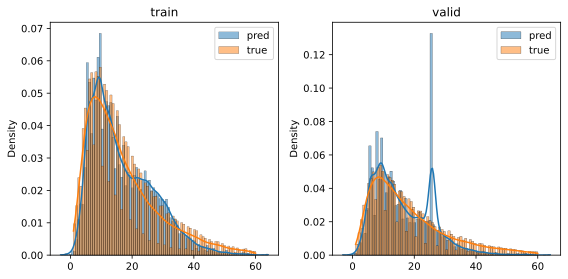

In [10]:
import pandas as pd

from toolz import compose

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer

from ride_duration.utils import plot_duration_histograms
from ride_duration.config import config
from ride_duration.processing import preprocess

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')


def convert_to_dict(df):
    return df.to_dict(orient="records")


def add_pudo_column(df):
    df["PU_DO"] = df["PULocationID"] + "_" + df["DOLocationID"]
    return df


# Load dataset
train = pd.read_parquet("data/green_tripdata_2021-01.parquet")
valid = pd.read_parquet("data/green_tripdata_2021-02.parquet")

# Preprocess
X_train, y_train = preprocess(train, target=True, filter_target=True)
X_valid, y_valid = preprocess(valid, target=True, filter_target=True)

# Feature engg + selection
transforms = [
    add_pudo_column,
    lambda df: df[["PU_DO"] + config.NUM_FEATURES]
]

X_train = compose(*transforms[::-1])(X_train)
X_valid = compose(*transforms[::-1])(X_valid)

# Fit model pipeline
pipe = make_pipeline(
    FunctionTransformer(convert_to_dict), 
    DictVectorizer(), 
    LinearRegression()
)

pipe.fit(X_train, y_train)

# Check performance
yp_train = pipe.predict(X_train)
yp_valid = pipe.predict(X_valid)
mse_train = mean_squared_error(y_train, yp_train, squared=False)
mse_valid = mean_squared_error(y_valid, yp_valid, squared=False)

# Plotting
_ = plot_duration_histograms(y_train, yp_train, y_valid, yp_valid)

In [11]:
print("RMSE (train):", mse_train)
print("RMSE (valid):", mse_valid)

RMSE (train): 5.699564118198945
RMSE (valid): 7.758715206931833


**Remark.** This exactly reproduces our [previous results](00-using-interaction-features). Note that the dict vectorizer in the pipeline returns a zero vector for categories it has not encountered in training.

## Code quality

Settings for [`isort`](https://github.com/PyCQA/isort), [pylint](https://pylint.readthedocs.io/en/latest/), and [`black`](https://github.com/psf/black) are included in the `pyproject.toml` file as follows. Warnings from pylint that are not relevant can be ignored as shown. Make sure to commit before running the formatters since they cause changes to the code.

```ini
# pyproject.toml
...

[tool.black]
line-length = 88
skip-string-normalization = true

[tool.isort]
multi_line_output = 3
length_sort = true

[tool.pylint.messages_control]
max-line-length = 88
disable = [
    "invalid-name",
    "wrong-import-position",
    "missing-class-docstring",
    "missing-function-docstring",
    "unspecified-encoding",
    "no-name-in-module",
    "missing-docstring",
    "wrong-import-order",
    "trailing-whitespace",
    "too-few-public-methods"
]
```

Running the formatters:

```bash
$ black .
reformatted /Users/particle1331/code/ride-duration-prediction/ride_duration/utils.py

All done! ✨ 🍰 ✨
1 file reformatted, 3 files left unchanged.
```

```bash
$ isort .
Fixing /Users/particle1331/code/ride-duration-prediction/ride_duration/config/core.py
Skipped 1 files
```

Suggestions from pylint can be followed iteratively until we are satisfied:

```bash
$ pylint --recursive=y ride_duration
************* Module ride_duration.processing
ride_duration/processing.py:14:4: R1705: Unnecessary "else" after "return", remove the "else" and de-indent the code inside it (no-else-return)
************* Module ride_duration.tests.test_processing
ride_duration/tests/test_processing.py:50:8: W0108: Lambda may not be necessary (unnecessary-lambda)

------------------------------------------------------------------
Your code has been rated at 9.87/10 (previous run: 9.80/10, +0.07)
```

<br>

```{figure} ../../img/black-diff.png
---
width: 45em
---
Code diff after using `black`.
```

### Code coverage


One metric for test completeness is **code coverage**. This can be checked using the [coverage](https://coverage.readthedocs.io/en/latest/) library as follows:

```bash
$ coverage run -m pytest ride_duration
======================== test session starts =========================
platform darwin -- Python 3.9.15, pytest-7.3.1, pluggy-1.0.0
rootdir: /Users/particle1331/code/ride-duration-prediction
plugins: anyio-3.7.0
collected 6 items

ride_duration/tests/test_config.py .                           [ 16%]
ride_duration/tests/test_pipeline.py ..                        [ 50%]
ride_duration/tests/test_processing.py ...                     [100%]

========================= 6 passed in 2.35s ==========================

$ coverage report -m
Name                                     Stmts   Miss  Cover   Missing
----------------------------------------------------------------------
ride_duration/__init__.py                    0      0   100%
ride_duration/config/__init__.py             1      0   100%
ride_duration/config/core.py                22      0   100%
ride_duration/processing.py                 15      0   100%
ride_duration/tests/__init__.py              0      0   100%
ride_duration/tests/conftest.py             13      0   100%
ride_duration/tests/test_config.py           7      0   100%
ride_duration/tests/test_pipeline.py        24      0   100%
ride_duration/tests/test_processing.py      24      0   100%
ride_duration/utils.py                      24     13    46%   24-40
----------------------------------------------------------------------
TOTAL                                      130     13    90%
```

**Remark.** Since our approach to testing has been to act as a form of documentation and integration (as opposed to strict [unit testing](https://realpython.com/python-cli-testing/#mocks)), a high number indicates that our examples cover most of the code base. Observe our tests fail to cover plotting which is fine since it only serves to make nice plots and has no virtually no point of failure.

### Makefile

Notice that the amount of commands that we need to run keeps growing as we proceed into the project. One way to simplify repetitive commands is by using [makefiles](http://www.sis.pitt.edu/mbsclass/tutorial/advanced/makefile/whatis.htm). Usual commands are collected in `./Makefile` as follows: 

```bash
clean: clean-test clean-build
	find . | grep ".vscode" | xargs rm -rf
	find . | grep ".DS_Store" | xargs rm
	find . | grep "__pycache__" | xargs rm -rf
	find . | grep ".ipynb_checkpoints" | xargs rm -rf

clean-build:
	rm -rf build/
	rm -rf dist/
	rm -rf .eggs/
	find . | grep ".egg" | xargs rm -rf
	find . | grep ".egg-info" | xargs rm -rf

clean-test:
	rm -f .coverage
	rm -rf htmlcov/
	find . | grep ".pytest_cache" | xargs rm -rf

lint:
	pylint --recursive=y ride_duration

test:
	pytest -W ignore -vv ride_duration

format:
	isort .
	black .

coverage:
	coverage run -m pytest ride_duration
	coverage report -m
```

The above computation of code coverage can now be done simply with:

```bash
$ make coverage
coverage run -m pytest ride_duration
=============== test session starts ===============
...
```

### Automated tests

In this section, we look at running **automated tests** at each pull request (PR) and push to the `main` branch. Note that we only do tests on the main branch. Tests for each push ensures that the
tests are executed in case there is direct push on the main branch. The following file based on [this reference](https://docs.github.com/en/actions/automating-builds-and-tests/building-and-testing-python) is created on the root directory of the project:

```yaml
# .github/workflows/tests.yml
name: tests

on:
  push:
    branches:
      - main
  pull_request:
    branches:
      - main

jobs:
  build:

    runs-on: ubuntu-latest
    strategy:
      matrix:
        python-version: ["3.9", "3.10"]

    steps:
      - uses: actions/checkout@v3
      - name: Set up Python ${{ matrix.python-version }}
        uses: actions/setup-python@v4
        with:
          python-version: ${{ matrix.python-version }}
      
      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install pipenv
          pipenv install --dev --system --deploy

      - name: Test with pytest
        run: |
          pytest -W ignore ride_duration
```

This shows that we run the tests on both Python 3.9 and 3.10 on an Ubuntu machine. The two important steps here are the installation step which installs Pipenv and the test step which runs pytest on our package. After committing this file to GitHub, we can see the workflow in the [Actions](https://docs.github.com/en/actions) tab:

```{figure} ../../img/actions-tab.png
---
width: 100%
---
Workflow automatically registers. This also provides a status badge for the `main` branch: [![Tests](https://github.com/particle1331/ride-duration-prediction/actions/workflows/tests.yml/badge.svg?branch=main)](https://github.com/particle1331/ride-duration-prediction/actions/workflows/tests.yml). Clicking the workflow name lists all runs for this workflow. The badge indicates that the latest run is successful.
```

Tests automatically run with every PR. Here we create a branch that [fails a test](https://github.com/particle1331/ride-duration-prediction/commit/550c536614cd34bc622a924347272a4f0ac36d63). Running tests on PRs ensures that failing code is not merged:

```{figure} ../../img/failing-test-pr.png
---
width: 100%
---
PR with a failing test. This should be closed. Note that the tests are run on Python 3.9 and 3.10 but other jobs are cancelled once one test fails.
```